In [40]:
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import time
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

%matplotlib inline

In [42]:
comments = pd.read_csv('final_dataset_cleaned_fourplus.csv')

In [43]:
comments.drop('Unnamed: 0',axis=1,inplace=True)

### Exploratory Data Analysis

In [44]:
comments.groupby('subreddit')['word length'].median()

subreddit
AskMen      28
AskWomen    35
Name: word length, dtype: int64

In [45]:
comments.groupby('subreddit')['score'].mean()

subreddit
AskMen      11.675393
AskWomen    11.167002
Name: score, dtype: float64

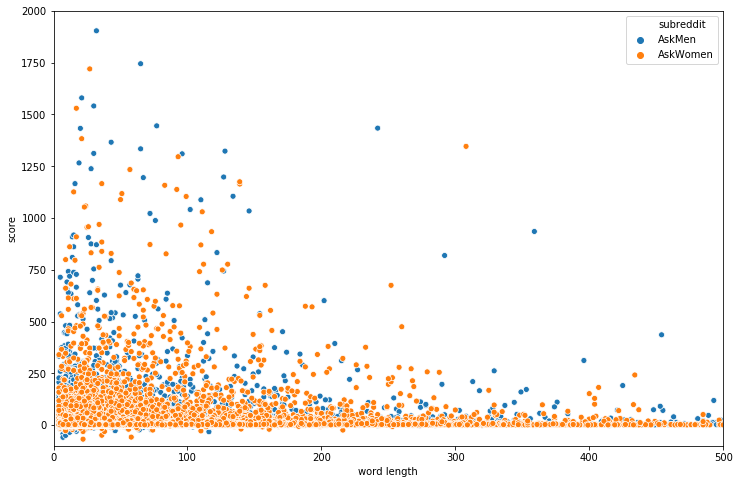

In [46]:
plt.figure(figsize=(12,8))
plt.xlim(0,500)
plt.ylim(-100,2000)
sns.scatterplot(x='word length',y='score', hue='subreddit', data=comments);

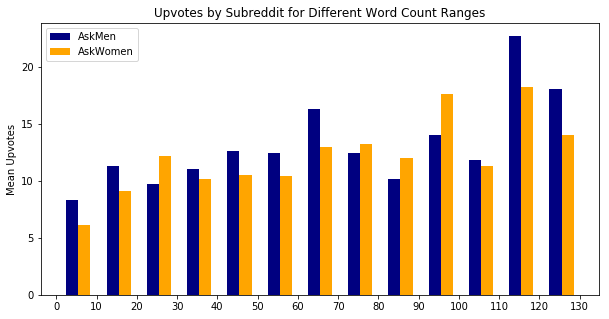

In [7]:
#generate lists of the gender survival rates for each age five year age group between 0 and 65
scoremeanlistm = [comments[(comments['subreddit']=='AskMen')&(comments['word length']>=i)&(comments['word length']<(i+10))]['score'].mean() for i in range(0,130,10)]
scoremeanlistw = [comments[(comments['subreddit']=='AskWomen')&(comments['word length']>=i)&(comments['word length']<(i+10))]['score'].mean() for i in range(0,130,10)]

#create figure
fig,ax = plt.subplots(figsize=(10,5))
plt.title('Upvotes by Subreddit for Different Word Count Ranges')
plt.ylabel('Mean Upvotes')

#generate side by side barplots
barWidth = 3
plt.bar(np.arange(4,134,10), scoremeanlistm, color='navy', width=barWidth, label='AskMen')
plt.bar(np.arange(7,137,10), scoremeanlistw, color='orange', width=barWidth, label='AskWomen')
 
plt.xticks(np.arange(0,140,10))

plt.legend();

There doesn't seem to be a whole lot in these visualizations

Exploratory Data Analysis on the available features here does not seem to give us very much.  Good thing we have NLP!

### Train Test Split

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X = comments['body']
y = comments['subreddit']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=True,stratify=y)

### Naive Bayes

In [31]:
# from sklearn.naive_bayes import MultinomialNB

In [32]:
# cv = CountVectorizer(max_features = 5000, stop_words = 'english')

In [33]:
# X_train_cv = pd.DataFrame(cv.fit_transform(X_train['body']).todense(),
#                           columns = cv.get_feature_names())

In [34]:
# X_test_cv = pd.DataFrame(cv.transform(X_test['body']).todense(),
#                          columns = cv.get_feature_names())

In [35]:
# nb = MultinomialNB()
# model_nb = nb.fit(X_train_cv, y_train)
# predictions = model_nb.predict(X_test_cv)

In [36]:
# model_nb.score(X_train_cv, y_train)

0.6763931505493418

In [37]:
# model_nb.score(X_test_cv, y_test)

0.646772373656393

I tried a few different values for the max_features argument: 500, 1000, 2000, 5000, 100000.  5000 seemed to give the best results without being too overfit.  Note that baseline accuracy for this model is about 53%, given the class balances.  So this is certainly an improvement.

### Logistic Regression

I attempted to run a GridSearch, but was running into kernel difficulties, so ended up testing individually

In [66]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

### Basic Logistic Regression

In [8]:
cv2 = CountVectorizer(stop_words = 'english')

In [9]:
X_train_cv = cv2.fit_transform(X_train)
X_test_cv = cv2.transform(X_test)

In [10]:
X_train_cv.shape

(50515, 45138)

In [14]:
logreg = LogisticRegression(penalty='l2',C=1)
model_lr = logreg.fit(X_train_cv, y_train)
predictions = model_lr.predict(X_test_cv)

In [15]:
model_lr.score(X_train_cv, y_train)

0.8472334950014847

In [16]:
model_lr.score(X_test_cv, y_test)

0.6628659659124652

### GridSearch with Logistic Regression, CountVec

In [11]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('model', LogisticRegression())
     ])

params = {
    'vect__ngram_range':[(1,2)],
    'vect__min_df':[2,5],
    'vect__stop_words':[None,'english'],
    'model__penalty':['l2','l1'],
    'model__C':[0.1, 1, 10],
}

gs_lr1 = GridSearchCV(pipe, params, cv=4, verbose=3, n_jobs=-1)

gs_lr1.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 14.4min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': [(1, 2)], 'vect__min_df': [2, 5], 'vect__stop_words': [None, 'english'], 'model__penalty': ['l2', 'l1'], 'model__C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [12]:
gs_lr1.score(X_train, y_train)

0.9105414233396021

In [13]:
gs_lr1.score(X_test, y_test)

0.7040798147158382

In [16]:
gs_lr1.best_estimator_.steps

[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=2,
          ngram_range=(1, 2), preprocessor=None, stop_words=None,
          strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
          tokenizer=None, vocabulary=None)),
 ('model',
  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]

### GridSearch with Logistic Regression, TdidfVec

In [67]:
pipe2 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', LogisticRegression())
     ])

params = {
    'vect__ngram_range':[(1,3)],
    'vect__min_df':[2,5],
    'vect__stop_words':[None,'english'],
    'model__penalty':['l2','l1'],
    'model__C':[0.1, 1, 10],
}

gs_lr2 = GridSearchCV(pipe2, params, cv=4, verbose=2, n_jobs=-1)

gs_lr2.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 14.4min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': [(1, 3)], 'vect__min_df': [2, 5], 'vect__stop_words': [None, 'english'], 'model__penalty': ['l2', 'l1'], 'model__C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [68]:
gs_lr2.score(X_train, y_train)

0.8380481045234089

In [69]:
gs_lr2.score(X_test, y_test)

0.7051487618029574

The TfidfVectorizer Logistic Regression is the model I saw the most success with.

In [70]:
gs_lr2.best_estimator_.steps

[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
          dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
          lowercase=True, max_df=1.0, max_features=None, min_df=5,
          ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
          stop_words=None, strip_accents=None, sublinear_tf=False,
          token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
          vocabulary=None)),
 ('model',
  LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]

In [71]:
coefs = pd.DataFrame(gs_lr2.best_estimator_.steps[1][1].coef_)

In [72]:
coefs.columns=gs_lr2.best_estimator_.steps[0][1].get_feature_names()

I'm going to save this for later use in a word cloud.

In [73]:
coef_ranks.to_csv('coefs_ranks')

In [74]:
predicts = gs_lr2.predict(X_test)

### Confusion Matrix for LogReg with Tfidf

In [76]:
def make_nice_conmat(y_test, preds):

    cmat = confusion_matrix(y_test, preds)
    print(f'Accuracy: {accuracy_score(y_test, preds)}')
    print(classification_report(y_test, preds))
    return pd.DataFrame(cmat, columns=['Predicted ' + str(i) for i in ['AskMen','AskWomen']],\
            index=['Actual ' + str(i) for i in ['AskMen','AskWomen']])

make_nice_conmat(y_test, predicts)

Accuracy: 0.7051487618029574
             precision    recall  f1-score   support

     AskMen       0.70      0.63      0.66      7755
   AskWomen       0.71      0.77      0.74      9084

avg / total       0.70      0.71      0.70     16839



,Predicted AskMen,Predicted AskWomen
Actual AskMen,4879,2876
Actual AskWomen,2089,6995


In [26]:
predictions = pd.DataFrame(gs_lr2.predict_proba(X))

In [27]:
predictions['text'] = comments['body']

In [39]:
predictions.sort_values(1)[0:25]

,0,1,text
29958,0.995476,0.004524,You need to be able to distinguish between a g...
9195,0.990102,0.009898,Start with a physical change. Get a good hairc...
46357,0.989392,0.010608,Seyi shay. Her composure!
10730,0.988990,0.011010,She’s my wife :)
62159,0.987332,0.012668,My wife walked with her mom.
5575,0.987021,0.012979,"Well, most likely if she’s sucking on yo dick ..."
6819,0.986445,0.013555,&gt;girl &gt;friend Pick one OP
23865,0.985701,0.014299,"Usually, you are attracted to the person befor..."
26589,0.985633,0.014367,You tried... She declined... She knows you tri...
20508,0.985479,0.014521,"Say nothing, don't answer any questions. Becau..."


### GridSearch with Logistic Regression, HashingVec

In [26]:
pipe3 = Pipeline([
    ('vect', HashingVectorizer()),
    ('model', LogisticRegression())
     ])

params = {
    'vect__ngram_range':[(1,3)],
    'vect__stop_words':[None,'english'],
    'model__penalty':['l2','l1'],
    'model__C':[0.1, 1, 10],
}

gs_lr3 = GridSearchCV(pipe3, params, cv=5, verbose=2, n_jobs=-1)

gs_lr3.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
         decode_error='strict', dtype=<class 'numpy.float64'>,
         encoding='utf-8', input='content', lowercase=True,
         n_features=1048576, ngram_range=(1, 1), non_negative=False,
         norm='l2', pr...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': [(1, 3)], 'vect__stop_words': [None, 'english'], 'model__penalty': ['l2', 'l1'], 'model__C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [28]:
gs_lr3.score(X_train, y_train)

0.9918242106305057

In [29]:
gs_lr3.score(X_test, y_test)

0.7064552526872142

The takeaways from this section with the logistic regression thus far has been some very good scoring even with cross-validation on the training set and then significant underperformance on the test set.  It's hard to determine why this is, especially given that the cross-validation during GridSearch should involve running the model on test data.  Close examination of the coefficients in the Tfidf model above show coefficients that are reasonably sized, and also very plausible as predictors.  So the models do seem to be working correctly.

My next move is to try and reduce the overfitting that we are apparently seeing.  I decided that to do this, I would run the Tfidf again with the best_estimator parameters, except I would try setting max_features.  I initially considered decreasing C to increase the strength of regularization penalties, but I noticed that the GridSearch chose the highest C available as the best estimator.

In [71]:
tfidf = TfidfVectorizer(max_features=3000, min_df=2, ngram_range=(1,3))

In [72]:
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [73]:
logreg_td = LogisticRegression(penalty='l2',C=10)
model_lrtd = logreg_td.fit(X_train_tf, y_train)

In [74]:
model_lrtd.score(X_train_tf,y_train)

0.7197466099178462

In [75]:
model_lrtd.score(X_test_tf,y_test)

0.6724271037472535

It appears that the overfitting is tied directly to the feature number.  As I raised the max from 3000 up to no max, the train score went up toward 1 while the test score remained roughly the same.

I also tried running with a different train test split later on, and the results were more reasonable, train scores in the 0.8-0.85 range.

### Modeling Only For Long Comments (>20 Words)

The last thing I am interested in here is how this will perform if I limit the comments to word length > 20.  It seems likely that the model will be able to be more accurate for full-length comments.

In [32]:
longcomments = comments[comments['word length']>=20].copy()

In [33]:
longcomments.head()

,body,created_utc,id,parent_id,score,subreddit,word length,elitecomment
0,I was 23 but I went with my ~29 year old cowor...,1545243578,ec4lbi4,t3_a7oy9v,1,AskMen,23,0
1,"Portland, OR. The city itself is now unafforda...",1545243546,ec4la0n,t3_a7mkui,1,AskMen,36,0
2,"nope. ""the cats goodbye"" watch how a cat says ...",1545243536,ec4l9lm,t3_a7fe60,1,AskMen,28,0
4,There was this one time when I went over one o...,1545243449,ec4l5g6,t3_a7kmvc,1,AskMen,192,0
6,lol...since college. and my oldest is 23 now. ...,1545243442,ec4l55k,t3_a7b265,1,AskMen,64,0


In [34]:
len(longcomments)

45194

In [35]:
X_long = longcomments['body']
y_long = longcomments['subreddit']
X_train_long, X_test_long, y_train_long, y_test_long = train_test_split(X_long,y_long,shuffle=True,stratify=y_long)

In [36]:
pipelong = Pipeline([
    ('vect', TfidfVectorizer()),
    ('model', LogisticRegression())
     ])

params = {
    'vect__ngram_range':[(1,3)],
    'vect__min_df':[2,5],
    'vect__stop_words':[None,'english'],
    'model__penalty':['l2','l1'],
    'model__C':[0.1, 1, 10],
}

gs_lr_long = GridSearchCV(pipelong, params, cv=4, verbose=2, n_jobs=-1)

gs_lr_long.fit(X_train_long, y_train_long)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 13.9min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'vect__ngram_range': [(1, 3)], 'vect__min_df': [2, 5], 'vect__stop_words': [None, 'english'], 'model__penalty': ['l2', 'l1'], 'model__C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [37]:
gs_lr_long.score(X_train_long,y_train_long)

0.998465850420416

In [38]:
gs_lr_long.score(X_test_long,y_test_long)

0.7258164439330914

There is a small improvement in predictive power, but for the most part the numbers mimic those seen in the wider set.